<a name="demo"></a>
## Interacting with SQLite from Python (30 min)

### The `sqlite3` package

The command line utility can be useful for basic SQL tasks, but since we're using python for the rest of code it will often be easier to access sqlite directly from within python.  We can use the python [`sqlite3`](https://docs.python.org/2.7/library/sqlite3.html) package for just this purpose.

Open a connection to an SQLite database file.  As before, if the file does not already exist it will automatically be created.

In [4]:
import sqlite3
sqlite_db = 'test_db.sqlite'
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

The syntax to create a table is similar to the console, only now we use the `execute` method of the cursor object `c` that we just created:

In [5]:
c.execute('CREATE TABLE houses (field1 INTEGER PRIMARY KEY, sqft INTEGER, bdrms INTEGER, age INTEGER, price INTEGER);')

# Save (commit) the changes
conn.commit()

With the database saved the table should now be viewable using SQLite Manager.

#### Adding data

Since we're back in python, we can now use regular programming techniques in conjunction with the sqlite connection.  In particular, the cursor's `execute()` method supports value substitutionusing the `?` character, which makes adding multiple records a bit easier.  See the [docs](https://docs.python.org/2.7/library/sqlite3.html) for more details.

In [4]:
last_sale = (None, 4000, 5, 22, 619000)
c.execute('INSERT INTO houses VALUES (?,?,?,?,?)',last_sale)

# Remember to commit the changes
conn.commit()

Notice that in this syntax we use the python `None` value, rather than `NULL`, to trigger SQLite to auto-increment the Primary Key. 

There is a related cursor method `executemany()` which takes an array of tuples and loops through them, substituting one tuple at a time.

In [6]:
recent_sales = [
  (None, 2390, 4, 34, 319000),
  (None, 1870, 3, 14, 289000),
  (None, 1505, 3, 90, 269000),
]

c.executemany('INSERT INTO houses VALUES (?, ?, ?, ?, ?)', recent_sales)

conn.commit()

Once again, use SQLite Manager to verify the database contents. 



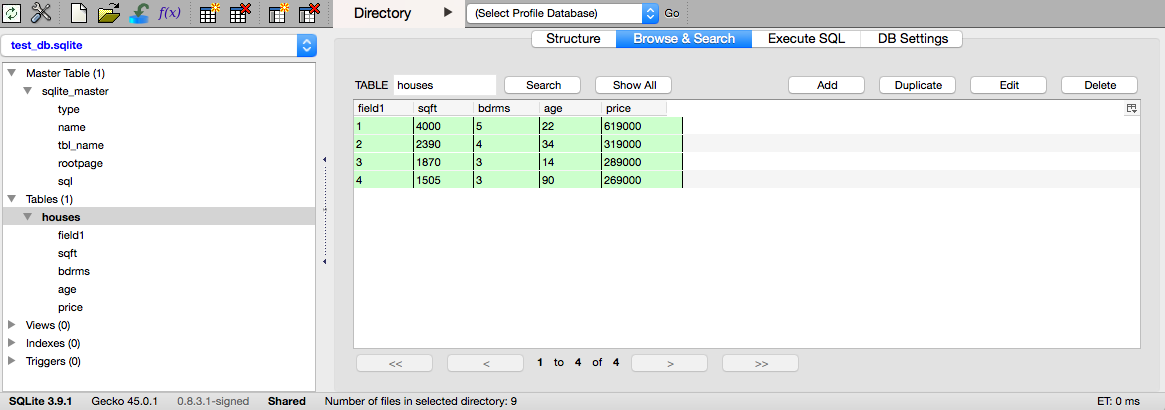

In [4]:

from IPython.display import Image
Image(filename='./images/SQLiteManager.png')

#### Adding data from a csv file
Next let's load our housing.csv data into an array, and then `INSERT` those records into the database.  In this example we'll use the numpy `genfromtxt` function to read the file and parse the contents. 

In [10]:
from numpy import genfromtxt

# import into nparray of ints, then convert to list of lists
data = (genfromtxt('datasets/housing-data.csv', dtype='i8', 
                    delimiter=',', skip_header=1)).tolist()

# append a None value to beginning of each sub-list
for d in data:
    d.insert(0, None)

In [11]:
data[0:3]

[[None, 2104, 3, 70, 399900],
 [None, 1600, 3, 28, 329900],
 [None, 2400, 3, 44, 369000]]

In [12]:
# loop through data, running an INSERT on each record (i.e. sublist)
for d in data:
    c.execute('INSERT INTO houses VALUES (?, ?, ?, ?, ?)', d)

conn.commit()

A reason for this example - remember that all elements in a numpy array must be the same data type, so if we want to 'add a None' to each row, we need to work around this.  Lists can contain mixed types, so that is one approach.

Still, in this case the value we're adding is the same for all records, so we could have simply used a 'None' in the INSERT statement directly.

**Check**: How do you delete data?

In [13]:
# similar syntax as before
results = c.execute("SELECT * FROM houses WHERE bdrms = 4")

# here results is a cursor object - use fetchall() to extract a list
results.fetchall()

[(1, 2390, 4, 34, 319000),
 (8, 3000, 4, 75, 539900),
 (9, 1985, 4, 61, 299900),
 (14, 1940, 4, 7, 239999),
 (19, 2300, 4, 77, 449900),
 (22, 2609, 4, 5, 499998),
 (23, 3031, 4, 21, 599000),
 (27, 1962, 4, 53, 259900),
 (36, 2040, 4, 75, 314900),
 (38, 1811, 4, 24, 285900),
 (41, 2132, 4, 28, 345000),
 (42, 4215, 4, 66, 549000),
 (43, 2162, 4, 43, 287000),
 (46, 2567, 4, 57, 314000),
 (49, 1852, 4, 64, 299900)]

### Pandas connector

While databases provide many analytical capabilities, often it's useful to pull the data back into Python for more flexible programming. Large, fixed operations would be more efficient in a database, but Pandas allows for interactive processing.

For example, if you want to aggregate nightly log-ins or sales to present a report or dashboard, this operation is likely not changing and operating on a large dataset. This can run very efficiently in a database rather than by connecting to it with Python.

However, if we want to investigate login or sales data further and ask more interactive questions, then Python would be more practical.

In [14]:
import pandas as pd
from pandas.io import sql

Pandas can connect to most relational databases. In this demonstration, we will create and connect to a SQLite database.

SQLite creates portable SQL databases saved in a single file. These databases are stored in a very efficient manner and allow fast querying, making them ideal for small databases or databases that need to be moved across machines.

### Writing data into a database

Data in Pandas can be loaded into a relational database. For the most part, Pandas can use column information to infer the schema for the table it creates. For the next demo we will use the Rossmann stores dataset.

In [16]:
import pandas as pd

data = pd.read_csv('datasets/housing-data.csv', low_memory=False)
data.head()

,sqft,bdrms,age,price
0,2104,3,70,399900
1,1600,3,28,329900
2,2400,3,44,369000
3,1416,2,49,232000
4,3000,4,75,539900


Data is moved to the database through the `to_sql` command, similar to the `to_csv` command.

`to_sql` takes as arguments:
    - `name`, the table name to create
    - `con`, a connection to a database
    - `index`, whether to input the index column
    - `schema`, if we want to write a custom schema for the new table
    - `if_exists`, what to do if the table already exists. We can overwrite it, add to it, or fail

In [17]:
data.to_sql('houses_pandas',
            con=conn,
            if_exists='replace',
            index=False)

### Reading data from a database

If we already have data in our database, we can use Pandas to query it. Querying is done through the `read_sql` command in the `sql` module.

In [19]:
sql.read_sql('select * from houses_pandas limit 10', con=conn)

,sqft,bdrms,age,price
0,2104,3,70,399900
1,1600,3,28,329900
2,2400,3,44,369000
3,1416,2,49,232000
4,3000,4,75,539900
5,1985,4,61,299900
6,1534,3,12,314900
7,1427,3,57,198999
8,1380,3,14,212000
9,1494,3,15,242500


<a name="guided-practice"></a>
## SQL Syntax (30 mins)

### SQL Operators
> Instructor Note: Each of the following can be demoed in pandas using the data we've setup above. A demo and check are included for each, but it is up to the instructor whether to do these simultaneously or go through them one at a time.

#### SELECT
Every query should start with `SELECT`.  `SELECT` is followed by the names of the columns in the output.

`SELECT` is always paired with `FROM`, and `FROM` identifies the table to retrieve data from.

```sql
SELECT
<columns>
FROM
<table>
```

`SELECT *` denotes returns *all* of the columns.

Housing Data example:
```sql
SELECT
sqft, bdrms
FROM houses_pandas;
```

**Check:** Write a query that returns the `sqft`, `bdrms` and `price`.
>
```sql
SELECT
sqft, bdrms, price
FROM houses_pandas;
```

#### WHERE
`WHERE` is used to filter table to a specific criteria and follows the `FROM` clause.

```sql
SELECT
<columns>
FROM
<table>
WHERE
<condition>
```
Example:
```sql
SELECT
sqft, bdrms, age, price
FROM houses_pandas
WHERE bdrms = 2 and price < 250000;
```

The condition is some filter applied to the rows, where rows that match the condition will be in the output.

**Check:** Write a query that returns the `sqft`, `bdrms`, `age` for when houses older than 60 years.
>```sql
SELECT
sqft, bdrms, age
FROM houses_pandas
WHERE age > 60;
```

### AGGREGATIONS

Aggregations (or aggregate functions) are functions where the values of multiple rows are grouped together as input on certain criteria to form a single value of more significant meaning or measurement such as a set, a bag or a list.

Examples of aggregate funtions:

- Average (i.e., arithmetic mean)
- Count
- Maximum
- Minimum
- Median
- Mode
- Sum

In SQL they are performed in a `SELECT` statement as follows.

```sql
SELECT COUNT(price)
FROM houses_pandas;
```

```sql
SELECT AVG(sqft), MIN(price), MAX(price)
FROM houses_pandas
WHERE bdrms = 2;
```

<a name="ind-practice"></a>
## Querying a Database (20 minutes)

Practice querying the SQLite database we've created using any of the methods you've learnt so far:

- console connection
- python `sqlite3` package
- pandas
- firefox browser extension [SQLite Manager](https://addons.mozilla.org/en-US/firefox/addon/sqlite-manager/?src)

Practice querying the PostgreSQL database you can find at:

    url: dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com
    port: 5432
    database: dsi
    user: dsi_student
    password: gastudents
    
using:
- console connection
- python `sqlalchemy` package
- pandas
- [Postico](https://eggerapps.at/postico/)


Questions:
1. What's the average price per room for 1 bedroom apartments?
1. What's the average price per room for 2 bedrooms apartments?
1. What's the most frequent apartment size (in terms of bedrooms)?
1. How many are there of that apartment kind?
1. What fraction of the total number are of that kind?
1. How old is the oldest 3 bedrooms apartment?
1. How old is the youngest apartment?
1. What's the average age for the whole dataset?
1. What's the average age for each bedroom size?

Try to answer all these in SQL.

If you finish, try completing the first sections of [SQL zoo](http://www.sqlzoo.net).

<a name="conclusion"></a>
## Conclusion (5 mins)
We have learnt how to connect to a local database and how to execute simple queries.

***
### ADDITIONAL RESOURCES

- [sqlite3 home](http://www.sqlite.org)  
- [SQLite - Python tutorial](http://sebastianraschka.com/Articles/2014_sqlite_in_python_tutorial.html)  
- [SQL zoo](http://www.sqlzoo.net)